In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.constants as const
import seaborn as sns

In [2]:
%matplotlib notebook

In [3]:
def Create_dataframes(filenames, directory, row_label, file_extension='csv'):
    dataframes = {}
    for name in filenames:
        file_directory = f'{directory}/{name}.{file_extension}'
        data = pd.read_csv(file_directory)
        dataframes[name] = data
    return dataframes

def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def Remove_rejects(All_variables, rejected_IDs):
    for variable_table in All_variables:
            variable_table.drop(rejected_IDs, inplace=True)
            
def Create_HR(dataframes, Teff_source, Rad_source):
    Teff_dataframe = dataframes[Teff_source]['Teff']
    Radius_dataframe = dataframes[Rad_source]['Radius']
    
    Total_data = [Teff_dataframe, Radius_dataframe]
    Filtered_data = Ensure_all(Total_data)
    Teff = Filtered_data['Teff']
    Radius = Filtered_data['Radius']
    
    Luminosity = Radius**2*(Teff/5772)**4
    return Teff, Luminosity

def Create_kdr(dataframes, data_source, variable_name, bandwidth=1):
    source = dataframes[data_source]
    sns.displot(source, x=f'{variable_name}', kind="kde", bw_adjust=bandwidth)

def Split_errors(database, variable_name, error_prefix=None, keep_columns=None):
    if error_prefix is None:
        error_prefix = variable_name
    try:
        if keep_columns is None:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me']]
        else:
            data = database[[f'{variable_name}', f'{error_prefix} pe', f'{error_prefix} me', *keep_columns]]
    except KeyError:
        half_pme = database[f'{error_prefix} pme']/2
        pe = half_pme.rename(f'{error_prefix} pe')
        me = half_pme.rename(f'{error_prefix} me')
        if keep_columns is None:
            data = database[f'{variable_name}']
        else:
            data = database[[f'{variable_name}', *keep_columns]]
            
        data = pd.merge(data, pe, left_index=True, right_index=True)
        data = pd.merge(data, me, left_index=True, right_index=True)
    return data

def Largest_error(errors, error_prefix):
    pe_column = f'{error_prefix} pe'
    me_column = f'{error_prefix} me'

    largest_errors = np.maximum(errors[pe_column], errors[me_column])

    return largest_errors

def Create_valley(starframes, planetframes, X_variable, X_error_prefix, X_source, PSR_source, Host_radii_source):
        
    #Checking for split errors
    PSR_data = Split_errors(planetframes[PSR_source], 'PSR', keep_columns=['Host Gaia DR3 ID'])
    
    #Checking for split errors
    Host_Radii_dataframe = Split_errors(starframes[Host_radii_source], 'Radius', 'Rad')
    
    if 'Planets' in X_source:
        X_data = Split_errors(planetframes[X_source], X_variable, X_error_prefix)
        Planet_data = [X_data, PSR_data]
        Planet_dataframe = Ensure_all(Planet_data).set_index('Host Gaia DR3 ID')
        Total_data = [Planet_dataframe, Host_Radii_dataframe]
    else:
        X_data = Split_errors(starframes[X_source], X_variable, X_error_prefix)
        Planet_dataframe = PSR_data.set_index('Host Gaia DR3 ID')
        Total_data = [Planet_dataframe, Host_Radii_dataframe, X_data]

    #Filtering out sources with no data and combining the dataframes
    Filtered_data = Ensure_all(Total_data)
    
    X = Filtered_data[X_variable]
    X_err = Filtered_data[[f'{X_error_prefix} pe', f'{X_error_prefix} me']]
    
    PSR = Filtered_data['PSR']
    PSR_err = Largest_error(Filtered_data, 'PSR')
    
    Host_Radii = Filtered_data['Radius']
    Host_Radii_err = Largest_error(Filtered_data, 'Rad')
    
    Sun_Earth = const.R_sun/const.R_earth
    Planet_Radii = PSR*Host_Radii*Sun_Earth
    Planet_Radii_err = Sun_Earth*np.sqrt(Host_Radii**2*PSR_err**2 + PSR**2*Host_Radii_err**2)
        
    return X, X_err, Planet_Radii, Planet_Radii_err

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
#Main_directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'

pre_BASTA_directory = f'{Main_directory}/Sorted Data/Stars'
post_BASTA_directory = f'{Main_directory}/BASTA/Output'

pre_filenames = ['Gaia All Stars', 'Exo All Stars', 'Fulton All Stars', 'VanEylen All Stars', 'BASTA All Stars', 'Grid test']

preframe = Create_dataframes(pre_filenames, pre_BASTA_directory, 'Gaia DR3 ID')

post_Gaia = pd.read_csv(f'{post_BASTA_directory}/GaiaResultsFinal.txt', sep='\t')
#post_Gaia.drop(post_Gaia.columns[-1], axis=1, inplace=True)

<IPython.core.display.Javascript object>


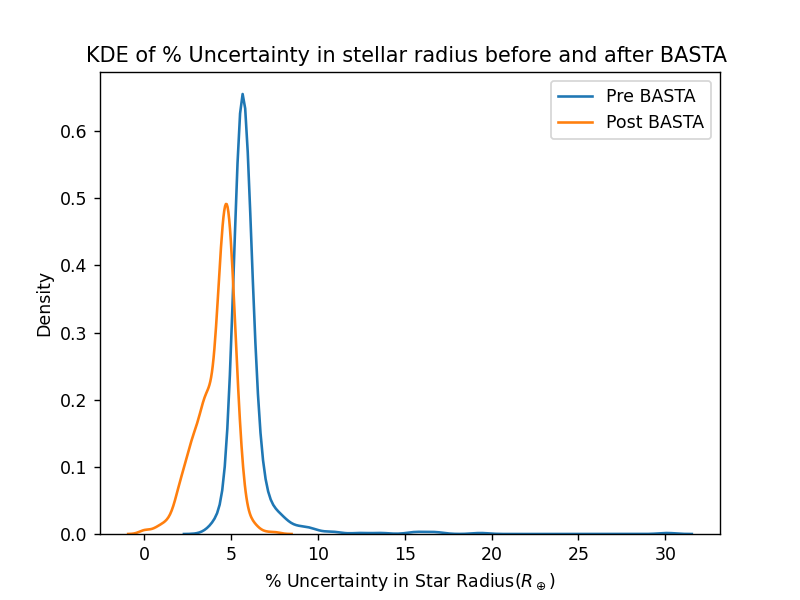

In [5]:
pre_Gaia = preframe['Gaia All Stars']
pre_Gaia['Radius'].dropna(inplace=True)
unc_sep0 = (pre_Gaia['Rad pe'] + pre_Gaia['Rad me'])/2
p_unc0 = unc_sep0/pre_Gaia['Radius']*100 + 3.5

post_Gaia['radPhot'].dropna(inplace=True)
unc_sep1 = (post_Gaia['radPhot_errp'] + post_Gaia['radPhot_errm'])/2
p_unc1 = unc_sep1/post_Gaia['radPhot']*100

plt.figure()
ax = sns.kdeplot(data=p_unc0, label='Pre BASTA')
sns.kdeplot(data=p_unc1, label='Post BASTA')
plt.xlabel(r'% Uncertainty in Star Radius($R_\oplus$)')
plt.title(r'KDE of % Uncertainty in stellar radius before and after BASTA ')
plt.legend()
#plt.savefig('Uncertainty KDE')

<IPython.core.display.Javascript object>


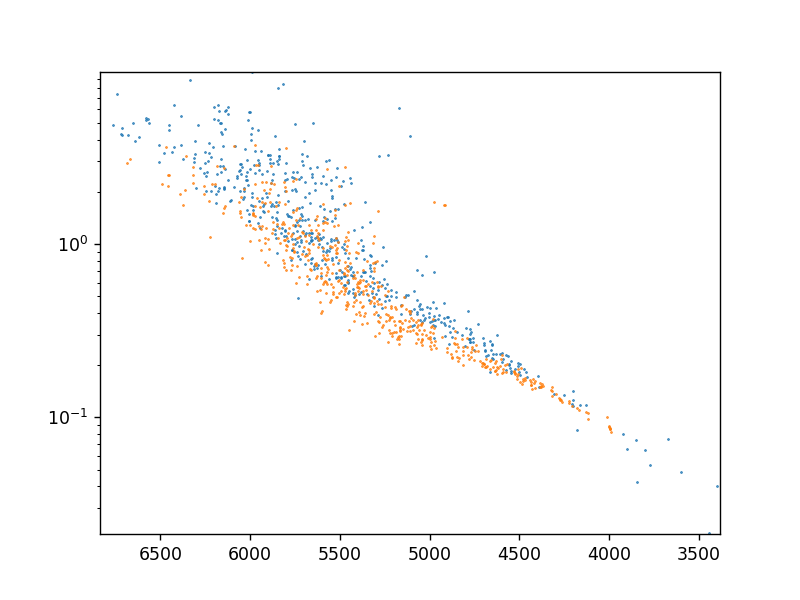

In [13]:
pre_radii = pre_Gaia['Radius']
pre_teff = pre_Gaia['Teff']

pre_lum = pre_radii**2*(pre_teff/5772)**4

data = pd.read_csv('C:/Users/Iwan/Documents/Work/Year 4 Project/GaiaResults.ascii', sep=' ')
post_radii = data['radPhot'].dropna()
post_teff = data['Teff'].dropna()

post_lum = post_radii**2*(post_teff/5772)**4

plt.figure()
plt.plot(pre_teff, pre_lum, '.', markersize=1)
plt.plot(post_teff, post_lum, '.', markersize=1)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.show()

<IPython.core.display.Javascript object>


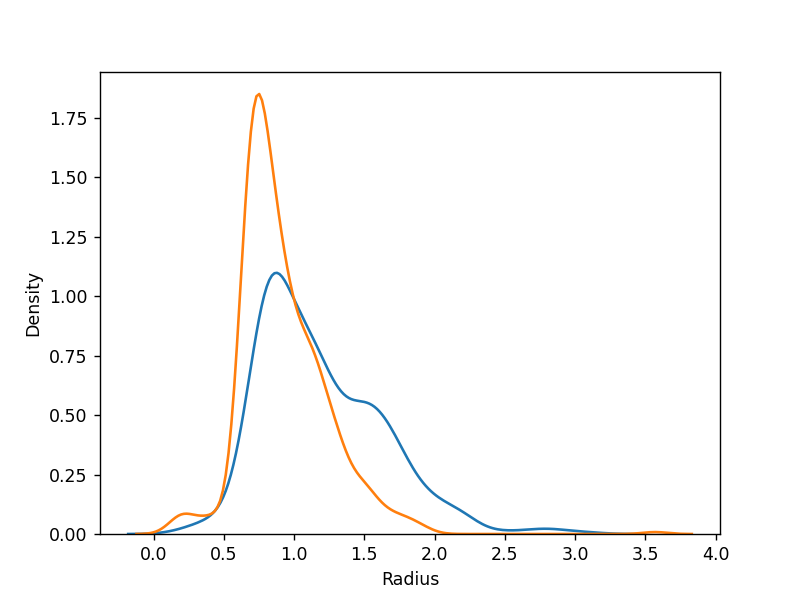

In [7]:
plt.figure()
ax = sns.kdeplot(pre_Gaia['Radius'])
sns.kdeplot(post_Gaia['radPhot'])
plt.show()

<IPython.core.display.Javascript object>


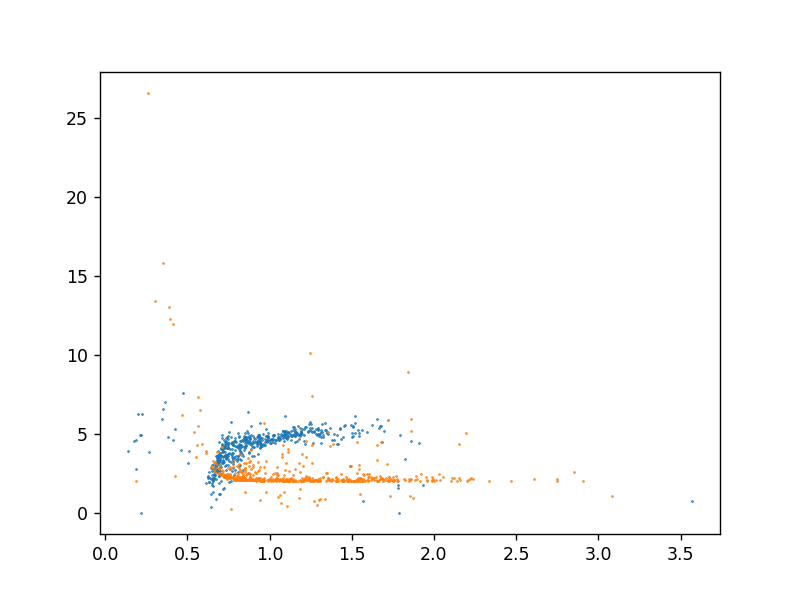

In [8]:
plt.figure()
plt.plot(post_Gaia['radPhot'], unc_sep1/post_Gaia['radPhot']*100, '.', markersize='1')
plt.plot(pre_Gaia['Radius'], unc_sep0/pre_Gaia['Radius']*100, '.', markersize='1')
#ax = sns.jointplot(x=post_Gaia['radPhot'], y=unc_sep1/post_Gaia['radPhot']*100, kind='hex')
#ax = sns.jointplot(x=pre_Gaia['Radius'], y=unc_sep0/pre_Gaia['Radius']*100, kind='hex')
#plt.ylim(1.5, 6)
#plt.xlim(0.5, 2)
plt.show()